In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import re
import seaborn as sns
import shapely
import tensorflow as tf
import visualkeras
import zipfile

import wandb
wandb.login()

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from keras.utils.np_utils import to_categorical
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm
from wandb.keras import WandbMetricsLogger, WandbEvalCallback, WandbModelCheckpoint


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # configure utilization of GPUs
    try:
        for gpu in gpus:
            # memory growth setting
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=256)]
            )
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        module_logger.error(e)


# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

wandb: Currently logged in as: stevo (hysped). Use `wandb login --relogin` to force relogin


In [2]:
def mkdir(path):
    if not os.path.isdir(path):
        if not os.path.exists(path):
            os.mkdir(path)
            
def predict_model(m, X, label_encoder):
    Y = m.predict(X)
    Y = np.argmax(Y, axis=1)
    Y = label_encoder.inverse_transform(Y)
    Y = pd.DataFrame(Y, columns=['Y_pred'])
    return Y

def plot_cm(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='Blues',
        # square=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        # annot_kws={'size': 12}
    )

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

## Configuration

In [60]:
cfg = dict(
    crs = 'EPSG:5514',
    figsize = (12,12),
    data_dir = os.path.join('..', 'data', 'Sverepec_spolu_preprocessed_top4'),
    models_dir = os.path.join('..', 'models'),
    class_column = 'DRUH_DR',
    model_name = 'conv1D_top4',
    num_conv1D_layers = 4,
)
cfg['project_name'] = 'hysped-%s' % cfg['model_name']

mkdir(cfg['models_dir'])
display(JSON(cfg, expanded=True))

<IPython.core.display.JSON object>

## Load data

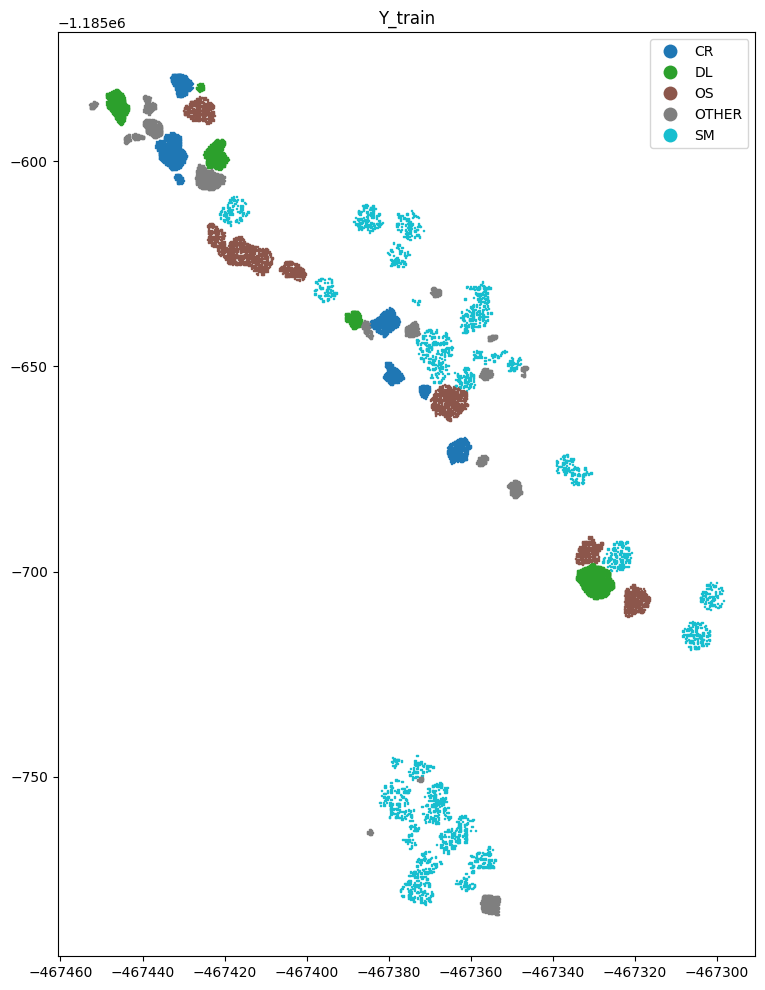

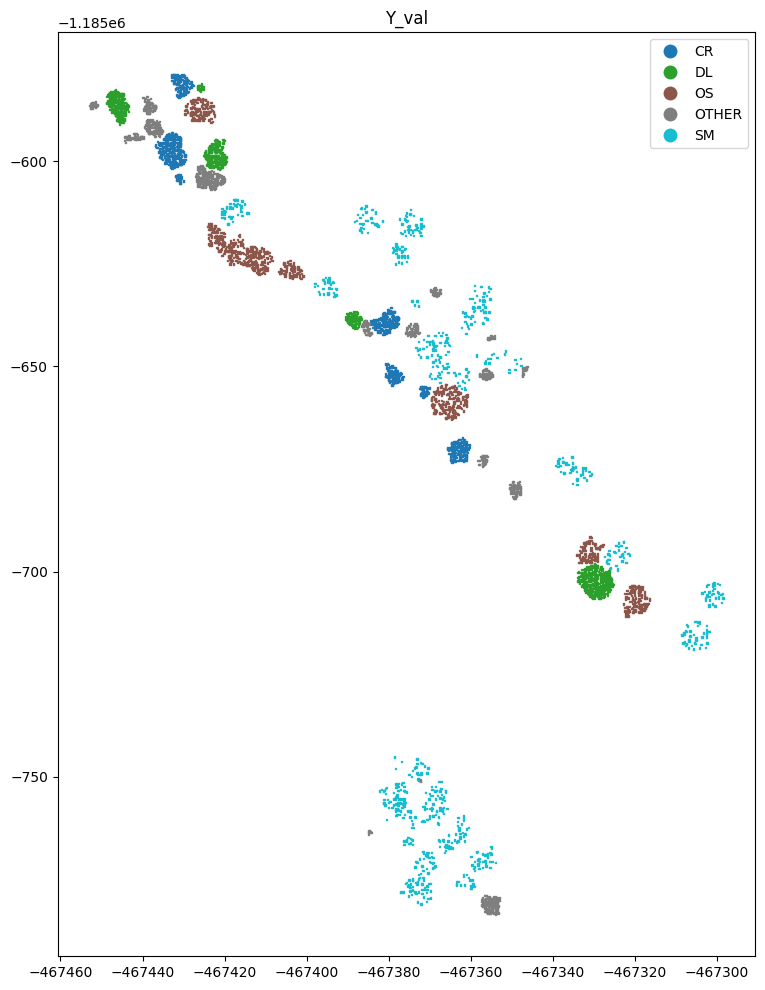

In [53]:
gdf_X_train = gpd.read_parquet(os.path.join(cfg['data_dir'], 'X_train.parquet'))
gdf_Y_train = gpd.read_parquet(os.path.join(cfg['data_dir'], 'Y_train.parquet'))
gdf_X_val = gpd.read_parquet(os.path.join(cfg['data_dir'], 'X_val.parquet'))
gdf_Y_val = gpd.read_parquet(os.path.join(cfg['data_dir'], 'Y_val.parquet'))

gdf_Y_train.plot(column=cfg['class_column'], legend=True, figsize=(12,12), marker=',', markersize=1)
plt.title('Y_train')
gdf_Y_val.plot(column=cfg['class_column'], legend=True, figsize=(12,12), marker=',', markersize=1)
plt.title('Y_val')
plt.show()

label_encoder = LabelEncoder()
encoder_filename = os.path.join(cfg['data_dir'], 'encoder-%s.npy' % cfg['class_column'])
label_encoder.classes_ = np.load(encoder_filename, allow_pickle=True)

num_classes = len(label_encoder.classes_)

X_train = gdf_X_train.values[:,1:]
Y_train = to_categorical(
    label_encoder.transform(gdf_Y_train[cfg['class_column']]),
    num_classes=num_classes
)

X_val = gdf_X_val.values[:,1:]
Y_val = to_categorical(
    label_encoder.transform(gdf_Y_val[cfg['class_column']]),
    num_classes=num_classes
)


X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
Y_val = Y_val.astype(np.float32)

## Model architecture

In [45]:
def make_model(
    input_shape: tuple,
    filters: [int],
    kernel_sizes: [int],
    num_classes: int,
    padding: str,
    **kwargs
):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Input(
            shape=input_shape
        )
    )
    model.add(
        tf.keras.layers.BatchNormalization()
    )
    
    for f,k in zip(filters, kernel_sizes):
        model.add(
            tf.keras.layers.Conv1D(
                filters=f,
                kernel_size=k,
                activation=tf.nn.relu,
                padding=padding
            )
        )
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes * 2))
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Softmax())
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

## Train model

In [46]:
config = dict(
    input_shape=(X_train.shape[1], 1),   
    filters=[1024,512,256,128],
    kernel_sizes=[15,9,7,5],
    num_classes=Y_train.shape[1],
    padding='valid'
)

run = wandb.init(
    project=cfg['project_name'],
    config=config,
)
logger.info('run.id: %s, run.name: %s' % (run.id, run.name))

model = make_model(**run.config)
model.summary()

model_dir = os.path.join(cfg['models_dir'], cfg['model_name'])
mkdir(model_dir)
logger.info('model_dir: %s' % model_dir)
model_file = os.path.join(model_dir, 'run_%s_model.h5' % (run.id))
logger.info('model_file: %s' % model_file)

wandbModelCheckpoint = WandbModelCheckpoint(
    model_file,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True
)

callbacks = [
    WandbMetricsLogger(),
    wandbModelCheckpoint,
]

history = model.fit(
    x=X_train,
    y=Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    shuffle=True,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

run.finish()
wandb.finish()

2023-04-13 10:18:50,470 | hysped | INFO : run.id: ir7n9lru, run.name: hardy-puddle-191
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 186, 1)           4         
 hNormalization)                                                 
                                                                 
 conv1d_12 (Conv1D)          (None, 172, 1024)         16384     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 86, 1024)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 78, 512)           4719104   
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 39, 512)          0         
 g1D)                            

epoch/categorical_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇████████████▇▇█████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁▁▂▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▅▇▇▇▇▇▇▇█▇▇██████▇███████▇█▆██▇█▇▇
epoch/val_loss,▃▇▇█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch/categorical_accuracy,0.91379
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.23997
epoch/val_categorical_accuracy,0.86136


## rolling the spectrum - test

In [171]:
dl = gdf_X_val[gdf_Y_val['DRUH_DR']=='DL'].head(1)
dl_x = dl.values[:,1:].astype(np.float32)
dl_x_pred = model.predict(dl_x)
print('dl_x_pred: %s' % dl_x_pred)
dl_x_pred = np.argmax(dl_x_pred)
dl_x_pred
dl_x_pred = label_encoder.inverse_transform([dl_x_pred])
print('dl_x_pred: %s' % dl_x_pred)

1/1 [==============================] - 0s 22ms/step
dl_x_pred: [[0.000053 0.993426 0.000725 0.005633 0.000164]]
dl_x_pred: ['DL']


In [172]:
dl_x_rolled = np.roll(dl_x, shift=10)
dl_x_pred_rolled = model.predict(dl_x_rolled)
print('dl_x_pred_rolled: %s' % dl_x_pred_rolled)
dl_x_pred_rolled = np.argmax(dl_x_pred_rolled)
dl_x_pred_rolled = label_encoder.inverse_transform([dl_x_pred_rolled])
print('dl_x_pred_rolled: %s' % dl_x_pred_rolled)

1/1 [==============================] - 0s 28ms/step
dl_x_pred_rolled: [[0.       0.       0.       0.998966 0.001034]]
dl_x_pred_rolled: ['OTHER']


## Confusion matrix

136/136 [==============================] - 1s 10ms/step


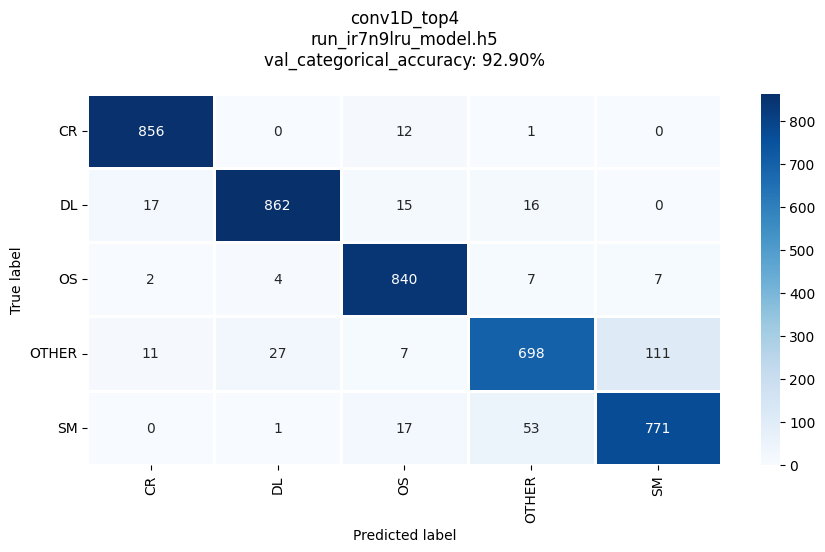

In [49]:
# load the best model
m = tf.keras.models.load_model(wandbModelCheckpoint.filepath)

Y_pred = predict_model(m, X_val, label_encoder=label_encoder)
cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(Y_val, axis=1)), Y_pred)

fig, ax = plt.subplots(figsize=(9,5))
plot_cm(ax, cm, labels=label_encoder.classes_)
plt.title('%s\n%s\n%s: %.2f%%\n' % (cfg['model_name'], os.path.basename(model_file), wandbModelCheckpoint.monitor, wandbModelCheckpoint.best * 100.0))
plt.show()

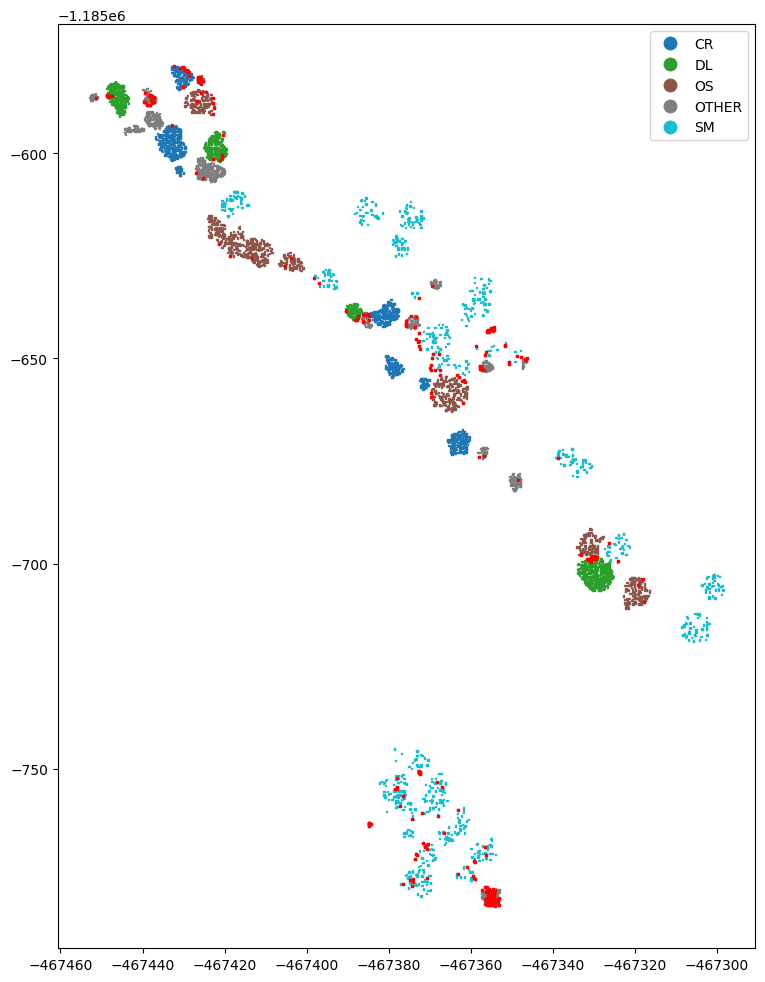

In [98]:
gdf_Y_val['Y_pred'] = Y_pred.values
gdf_Y_val['hit'] = gdf_Y_val[cfg['class_column']] == gdf_Y_val['Y_pred']
gdf_Y_val[~gdf_Y_val['hit']]

ax = gdf_Y_val.plot(column=cfg['class_column'], legend=True, figsize=cfg['figsize'], marker=',', markersize=1)
ax = gdf_Y_val[~gdf_Y_val['hit']].plot(ax=ax, legend=True, figsize=(20,20), marker=',', markersize=1, color='red')
plt.savefig('top4_validation_redasfalsehit.pdf', format='pdf')
plt.show()

## Hyperparameter tuning

In [8]:
# Define the search space
sweep_configuration = {
    'method': 'random',
    'metric': {
        'goal': 'maximize',
        'name': 'val_categorical_accuracy'
    },
    'parameters': {
        'input_shape': {
            'values': [(X_train.shape[1], 1)]
        },
        'num_classes': {
            'values': [num_classes]
        },
        'kernel_sizes': {
            'values': [
                [kernel_size for conv1d_layer in range(cfg['num_conv1D_layers'])] for kernel_size in [3,5,7,9,11,13,15]
            ]
        },
        'filters': {
            'values': [
                [2**(conv1d_layer+i) for conv1d_layer in range(cfg['num_conv1D_layers'],0,-1)] for i in range(8)
            ]
        },
        'batch_size': {
            'values': [
                128
            ]
        },
        'padding': {
            'values': [
                'causal'
            ]
        }
    }
}

display(JSON(sweep_configuration, expanded=True))

<IPython.core.display.JSON object>

In [ ]:
def main():
    run = wandb.init()
    model = make_model(**wandb.config)
    
    model_dir = os.path.join(cfg['models_dir'], cfg['model_name'])
    mkdir(model_dir)
    logger.info('model_dir: %s' % model_dir)
    model_file = os.path.join(model_dir, 'run_%s_model.h5' % (run.id))
    logger.info('model_file: %s' % model_file)
    
    wandbModelCheckpoint = WandbModelCheckpoint(
        model_file,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True
    )

    callbacks = [
        WandbMetricsLogger(),
        wandbModelCheckpoint,
    ]

    history = model.fit(
        x=X_train,
        y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=50,
        shuffle=True,
        batch_size=wandb.config.batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    wandb.log({
        wandbModelCheckpoint.monitor: wandbModelCheckpoint.best
    })
    run.finish()
    # wandb.log(pd.DataFrame(history.history)[-1:].reset_index(drop=True).to_dict(orient='records')[0])

# Start the sweep
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project=cfg['project_name']
)
wandb.agent(sweep_id, function=main, count=50)
wandb.finish()

Create sweep with ID: nqd1nv85
Sweep URL: https://wandb.ai/hysped/hysped-conv1D_top4/sweeps/nqd1nv85


wandb: Agent Starting Run: 3o0ivppk with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32, 16]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5, 5]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 21:21:25,564 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 21:21:25,565 | hysped | INFO : model_file: ../models/conv1D_top4/run_3o0ivppk_model.h5
Epoch 1/50
80/80 [==============================] - 5s 31ms/step - loss: 1.4462 - categorical_accuracy: 0.3564 - val_loss: 1.6608 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 2s 20ms/step - loss: 1.2118 - categorical_accuracy: 0.4979 - val_loss: 2.1550 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 2s 20ms/step - loss: 1.0581 - categorical_accuracy: 0.5582 - val_loss: 2.7103 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 2s 20ms/step - loss: 1.0020 - categorical_accuracy: 0.5873 - val_loss: 3.5606 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 1s 19ms/step - loss: 0.9011 - categorical_accuracy: 0.6294 - val_loss: 3.4015 - val_categorical_accuracy: 0.2309
Ep

epoch/categorical_accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▂▅▅▇▆▇▇▇▇▇▇▇▇█▇████████████████████
epoch/val_loss,▄▅▆█▆▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.84261
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.43551


wandb: Agent Starting Run: d2vvkdvh with config:
wandb: 	batch_size: 128
wandb: 	filters: [2048, 1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9, 9]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 21:22:59,320 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 21:22:59,321 | hysped | INFO : model_file: ../models/conv1D_top4/run_d2vvkdvh_model.h5
Epoch 1/50
80/80 [==============================] - 23s 243ms/step - loss: 1.3440 - categorical_accuracy: 0.4151 - val_loss: 3.5157 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 17s 215ms/step - loss: 0.9300 - categorical_accuracy: 0.6176 - val_loss: 4.6056 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 19s 233ms/step - loss: 0.7571 - categorical_accuracy: 0.6976 - val_loss: 3.6308 - val_categorical_accuracy: 0.2005
Epoch 4/50
80/80 [==============================] - 17s 206ms/step - loss: 0.7208 - categorical_accuracy: 0.7085 - val_loss: 4.1787 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 17s 210ms/step - loss: 0.6647 - categorical_accuracy: 0.7358 - val_loss: 4.3050 - val_categorical_accuracy:

epoch/categorical_accuracy,▁▄▅▆▆▆▇▇▇█▇▇▇███▇███
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▂▂▃▂▂▂▂▂▁▁▃▁▁▁
epoch/val_categorical_accuracy,▁▁▁▁▁▁▄▄▇██▆▇██▆████
epoch/val_loss,▆█▆▇█▄▃▃▁▁▁▂▁▁▁▃▁▁▁▁
epoch/categorical_accuracy,0.86436
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.36016
epoch/val_categorical_accuracy,0.88443


Run d2vvkdvh errored: ResourceExhaustedError()
wandb: ERROR Run d2vvkdvh errored: ResourceExhaustedError()
wandb: Agent Starting Run: mqeeflrr with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9, 9]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 21:29:08,275 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 21:29:08,276 | hysped | INFO : model_file: ../models/conv1D_top4/run_mqeeflrr_model.h5
Epoch 1/50
80/80 [==============================] - 10s 88ms/step - loss: 1.3048 - categorical_accuracy: 0.4357 - val_loss: 1.7271 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 6s 79ms/step - loss: 0.9917 - categorical_accuracy: 0.5796 - val_loss: 3.9166 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 6s 76ms/step - loss: 0.8546 - categorical_accuracy: 0.6469 - val_loss: 3.8956 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 6s 75ms/step - loss: 0.6794 - categorical_accuracy: 0.7318 - val_loss: 3.6729 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 6s 76ms/step - loss: 0.6964 - categorical_accuracy: 0.7188 - val_loss: 5.4947 - val_categorical_accuracy: 0.1970
E

epoch/categorical_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇█▇▇▇█▇██████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▂▂▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▁▁▁▁▃▅▆▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇█▇██████████████▇
epoch/val_loss,▄██▇█▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.88581
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.32676


wandb: Agent Starting Run: uv6jr0tb with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11, 11]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 21:35:17,184 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 21:35:17,186 | hysped | INFO : model_file: ../models/conv1D_top4/run_uv6jr0tb_model.h5
Epoch 1/50
80/80 [==============================] - 8s 63ms/step - loss: 1.2896 - categorical_accuracy: 0.4428 - val_loss: 1.8428 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 4s 45ms/step - loss: 0.9278 - categorical_accuracy: 0.6154 - val_loss: 2.5159 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 3s 40ms/step - loss: 0.7863 - categorical_accuracy: 0.6732 - val_loss: 2.7453 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 4s 45ms/step - loss: 0.7204 - categorical_accuracy: 0.7123 - val_loss: 2.4533 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 4s 45ms/step - loss: 0.6681 - categorical_accuracy: 0.7365 - val_loss: 3.2756 - val_categorical_accuracy: 0.1970
Ep

epoch/categorical_accuracy,▁▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████▇█████▇███████▇██
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁
epoch/val_categorical_accuracy,▁▁▁▁▂▃▅▇▇▇▇█▇▇▇███████▇████▇▇███████▇███
epoch/val_loss,▅▇█▇▆▅▃▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.89511
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.29236


wandb: Agent Starting Run: eqmi9fgu with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13, 13]
wandb: 	num_classes: 5
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-07 21:38:33,006 | hysped | INFO : model_dir: ../models/conv1D_top4
2023-04-07 21:38:33,007 | hysped | INFO : model_file: ../models/conv1D_top4/run_eqmi9fgu_model.h5
Epoch 1/50
80/80 [==============================] - 15s 143ms/step - loss: 1.2924 - categorical_accuracy: 0.4416 - val_loss: 3.8885 - val_categorical_accuracy: 0.1970
Epoch 2/50
80/80 [==============================] - 9s 107ms/step - loss: 0.8980 - categorical_accuracy: 0.6227 - val_loss: 6.7344 - val_categorical_accuracy: 0.1970
Epoch 3/50
80/80 [==============================] - 9s 111ms/step - loss: 0.7748 - categorical_accuracy: 0.6802 - val_loss: 5.4731 - val_categorical_accuracy: 0.1970
Epoch 4/50
80/80 [==============================] - 9s 110ms/step - loss: 0.7461 - categorical_accuracy: 0.6894 - val_loss: 5.2374 - val_categorical_accuracy: 0.1970
Epoch 5/50
80/80 [==============================] - 9s 111ms/step - loss: 0.7124 - categorical_accuracy: 0.7065 - val_loss: 3.8529 - val_categorical_accuracy: 0.1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



80/80 [==============================] - 6s 71ms/step - loss: 0.4032 - categorical_accuracy: 0.8502 - val_loss: 0.6928 - val_categorical_accuracy: 0.7435
Epoch 20/50
80/80 [==============================] - 6s 70ms/step - loss: 0.5180 - categorical_accuracy: 0.8058 - val_loss: 0.3860 - val_categorical_accuracy: 0.8535
Epoch 21/50
80/80 [==============================] - 6s 71ms/step - loss: 0.3817 - categorical_accuracy: 0.8610 - val_loss: 0.5048 - val_categorical_accuracy: 0.7910
Epoch 22/50
80/80 [==============================] - 6s 70ms/step - loss: 0.4255 - categorical_accuracy: 0.8420 - val_loss: 0.2932 - val_categorical_accuracy: 0.8865
Epoch 23/50
80/80 [==============================] - 7s 94ms/step - loss: 0.3670 - categorical_accuracy: 0.8665 - val_loss: 0.2911 - val_categorical_accuracy: 0.8870
Epoch 24/50
80/80 [==============================] - 6s 71ms/step - loss: 0.3433 - categorical_accuracy: 0.8714 - val_loss: 0.4371 - val_categorical_accuracy: 0.8254
Epoch 25/50
80/8

## Best model evaluation

In [6]:
api = wandb.Api()
model_artifact = api.artifact('hysped/hysped-conv1D_top4/run_mqeeflrr_model:v13', type='model')
model_path = model_artifact.download()
model = tf.keras.models.load_model(model_artifact.file())
model.summary()

wandb: Downloading large artifact run_mqeeflrr_model:v13, 71.23MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 186, 1)           4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 186, 1024)         10240     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 93, 1024)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 93, 512)           4719104   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 46, 512)          0         
 1D)                                                             
                                                        

136/136 [==============================] - 1s 7ms/step - loss: 0.1811 - categorical_accuracy: 0.9391


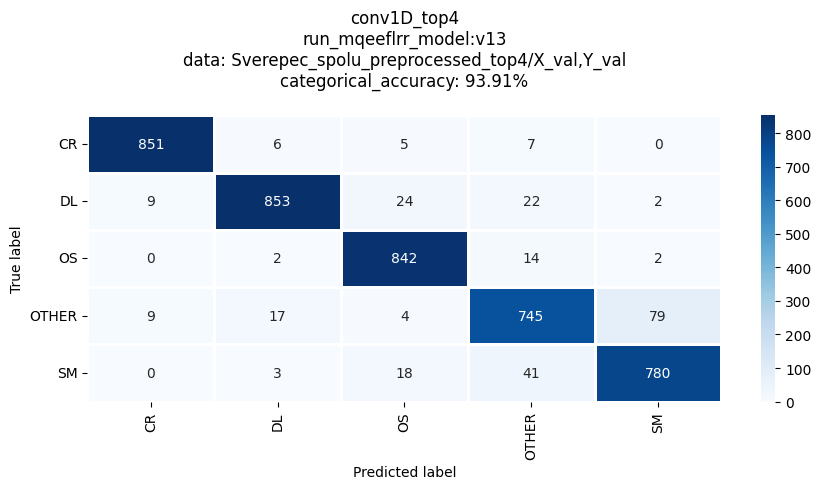

In [7]:
Y_pred = predict_model(model, X_val, Y_val, label_encoder=label_encoder)
cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(Y_val, axis=1)), Y_pred)

eval_results = model.evaluate(X_val, Y_val, return_dict=True)
metric_name = 'categorical_accuracy'

fig, ax = plt.subplots(figsize=(9,5))
plot_cm(ax, cm, labels=label_encoder.classes_)
plt.title('%s\n%s\ndata: %s/X_val,Y_val\n%s: %.2f%%\n' % (
    cfg['model_name'],
    model_artifact.name,
    os.path.basename(cfg['data_dir']),
    metric_name,
    float(eval_results[metric_name]) * 100.0)
)
plt.tight_layout()
plt.savefig(os.path.join(cfg['data_dir'], 'cm-%s.pdf' % model_artifact.name), format='pdf')
plt.show()

In [16]:
tf.keras.utils.plot_model(
    model,
    to_file=os.path.join(cfg['data_dir'], '%s-arch.pdf' % model_artifact.name),
    expand_nested=True,
    show_shapes=True,
    show_layer_activations=True
)

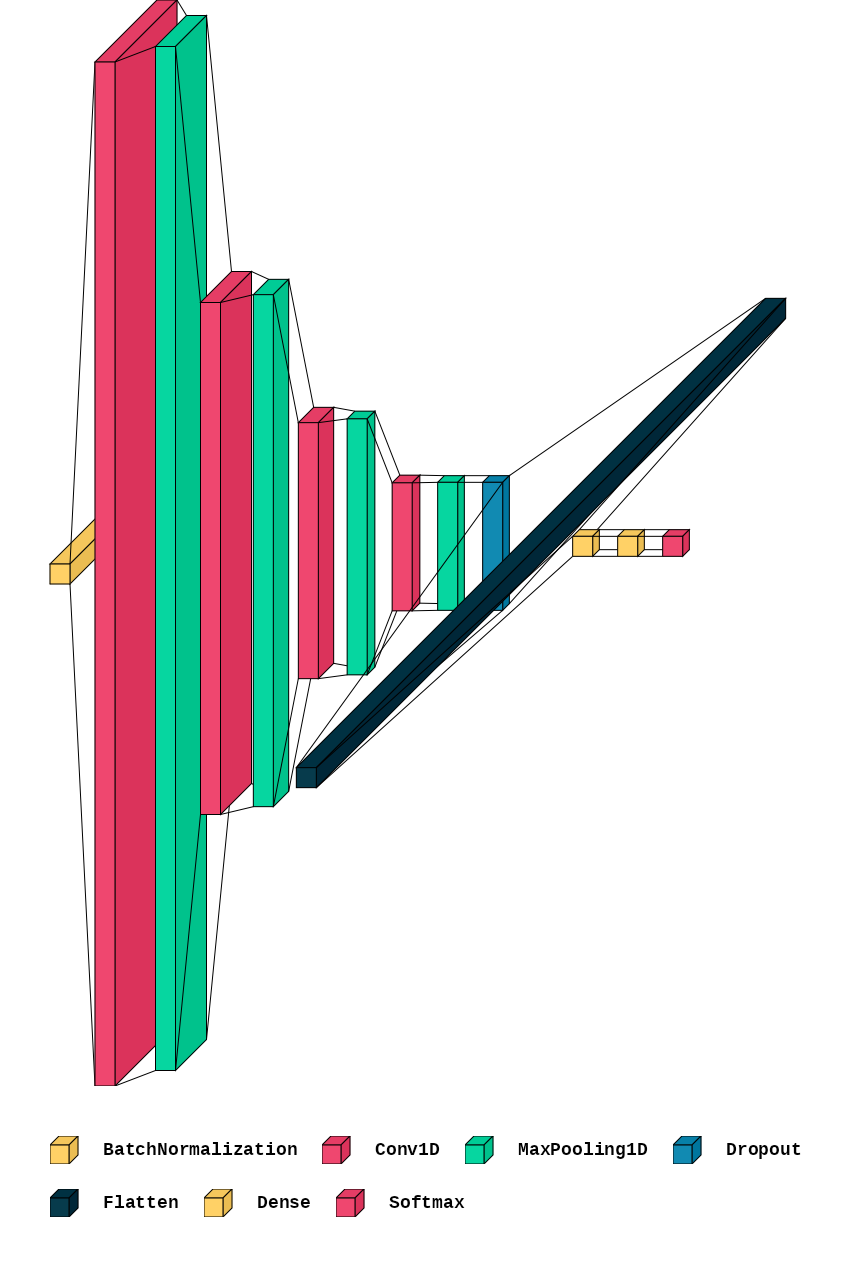

In [17]:
from PIL import ImageFont

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 18)

visualkeras.layered_view(
    model,
    to_file=os.path.join(cfg['data_dir'], '%s-arch.png' % model_artifact.name),
    legend=True,
    scale_xy=1,
    scale_z=1,
    one_dim_orientation='x',
    padding=50,
    spacing=25,
    font=font
)